# Lindhard susceptibility $\chi_0$ for a non interacting electron gas


The Lindhard function is defined by the equation

\begin{equation}
  \chi_0(\mathbf{q}, i\omega_n) = 
    -2\frac{1}{\beta N}\sum_{\mathbf{k}, m} 
    G_0(\mathbf{k}, i\nu_m)G_0(\mathbf{k}+\mathbf{q}, i\omega_n + i\nu_m) 
\end{equation}

where $\mathbf{q}$ and $\mathbf{k}$ are momenta and $i\omega_n$ and $i\nu_m$ are Bosonic and Fermionic Matsubara frequencies, respectively, and N the number of $\mathbf{k}$ points.

Since the equation is a convolution in both momentum and frequency space the calculation can be done in fewer operations by Fourier transforming to imaginary time $\tau$ and real space $\mathbf{r}$ for the Green's function, using fast Fourier transforms (FFT) to compute

$$
G_0(\mathbf{r}, \tau) = 
  \mathcal{F}_{\{\mathbf{k}, i\nu_m\} \rightarrow \{\mathbf{r}, \tau\}} 
  \big\{ G_0(\mathbf{k}, i\omega_n) \big\}.
$$

In real space $\mathbf{r}$ and imaginary time $\tau$ the convolution for $\chi_0$ is a simple product (since it corresponds to a simple bubble diagram with a particle-hole excitation)

$$
\chi_0(\mathbf{r},\tau) = -2 G_0(\mathbf{r},\tau)G_0(-\mathbf{r},\beta -\tau)
$$

and finally one goes back to momentum and Matsubara frequency by two more fast Fourier transforms

$$ 
  \chi_0(i\omega_n, k) \equiv 
  \mathcal{F}_{\{\mathbf{r},\tau\} \rightarrow \{\mathbf{k}, i\omega_n\}} 
  \big\{ \chi_0(\mathbf{r}, \tau) \big\}
$$


The goal of this notebook is to compute $\chi_0$ and study it, plot it.

Q: **How many operations are saved by using fast Fourier transforms rather than evaluating the convolutions?**

Q: **At what momenta $\mathbf{k}$ does the susceptibility $\chi_0$ have a maxima at zero frequency?**

Q: **How is the postiion of that maximum related to the Fermi surface?**
   

## Computing $\chi_0$ in C++

While it is possible to compute $\chi_0$ in Python, it is relatively slow, due to the required double loop over $r$ and $\tau$. So we use again the "C++ magic" of TPSC-1

The function bubble below computes the Lindhard function performing the three steps described above.


In [37]:
# Imports 
%matplotlib inline
from pytriqs.lattice import BravaisLattice, BrillouinZone
from pytriqs.gf import MeshBrillouinZone, MeshImFreq, Gf, MeshProduct, Idx
from pytriqs.archive import HDFArchive
from pytriqs.plot.mpl_interface import oplot
import numpy as np
from math import cos, pi
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,9) # set default size for all figures

In [38]:
%reload_ext cpp2py.magic

May take a few seconds to compile ...

In [40]:
%%cpp2py -C pytriqs
#include <triqs/gfs.hpp>
using namespace triqs::gfs;

// The type of a Green function : (k,omega) -> Complex number
using g_k_w_type = gf_view<cartesian_product<brillouin_zone, imfreq>, scalar_valued>;
using g_r_t_type = gf<cartesian_product<cyclic_lattice, imtime>, scalar_valued>;

g_k_w_type bubble(g_k_w_type g0) {
    
    // Fourier Transformation of k, \omega to obtain g(r,t)
    auto grt = make_gf_from_fourier<0,1>(g0);
    
    // The mesh of gtr is a cartesian product mt x mr. We decompose it.
    auto [mr, mt] = grt.mesh();
    
    // The inverse temperature from the mesh
    double beta = mt.domain().beta;
    
    // A new mesh for chi, with a bosonic statistics, but same size as mt.
    auto mtb = gf_mesh<imtime>{beta, Boson, mt.size()};
    
    // Build chi (r, tau) with this new mesh.
    auto chi0 = g_r_t_type{{mr, mtb}};

    // we fill chi : chi(tau, r) = g(beta - tau, -r) * g(tau, r)
    for (auto const &r : mr)      
        for (auto const &t : mtb) 
            chi0[r, t] = grt(-r, beta - t) * grt(r, t); 

    // Fourier transform back to k, \omega space and return
    return make_gf_from_fourier<0,1>(chi0);
}

## Compute the Lindhard susceptibility $\chi_0(\mathbf{k}, i\omega_n)$


In [41]:
# Reload the g0 from TPSC 1
with HDFArchive("tpsc.h5",'r') as R:
    g0 = R['g0_kw']

chi0_kw = bubble(g0)

# Save it for later reuse
with HDFArchive("tpsc.h5") as R:
    R['chi0_kw'] = chi0_kw

## Static Lindhard susceptibility $\chi_0(k, \omega=0)$

The square lattice with nearest-neighbour hopping $t$ has a property called "perfect nesting", meaning that large parts of the Fermi surface are mapped on to each other by a single momentum transfer $\mathbf{k}_{nesting}$, where $\mathbf{k}_{nesting}$ is called the "nesting vector". 

Go back to the fermi-surface polot of $\epsilon(\mathbf{k})$ and determine this peculiar momentum vector.

The "perfect nesting" greatly enhances the particle-hole susceptibility $\chi_0$ of the system and the static Lindhard susceptibility $\chi_0(\mathbf{k}, \omega=0)$ has a dominant peak at this momentum.

This can be seen as follows. Using the expression for the Greens function and performing the sum over Matsubara frequencies, one finds that the susceptibility (Lindhard function at $i\omega_n=0$ takes the form

\begin{equation}
  \chi_0(\mathbf{q}, 0) = 
    -2\frac{1}{\beta N}\sum_{\mathbf{k}, m} 
    G_0(\mathbf{k}, i\nu_m)G_0(\mathbf{k}+\mathbf{q}, i\nu_m)= -\frac{2}{\beta N}\sum_{\mathbf{k}}\frac{f(\epsilon(\mathbf{k}))-f(\epsilon(\mathbf{k+q}))}{\epsilon(\mathbf{k})-\epsilon(\mathbf{k+q})}.
\end{equation}

The form appears natural if we just think of the form of the structure of perturbation theory. At $\mathbf{q}=\mathbf{Q}=(\pi,\pi)$, the property of the cosine give that $\epsilon(\mathbf{k+Q})=-\epsilon(\mathbf{k})$. And since $f(-\epsilon(\mathbf{k}))=1-f(\epsilon(\mathbf{k}))$ we have

\begin{equation}
  \chi_0(\mathbf{q}, 0) = 
    -\frac{2}{\beta N}\sum_{\mathbf{k}}\frac{\tanh(\beta\epsilon(\mathbf{k})/2)}{2\epsilon(\mathbf{k})}
\end{equation}
which clearly diverges at $T=0$ when $\beta=\infty$.

## Plot the susceptibility

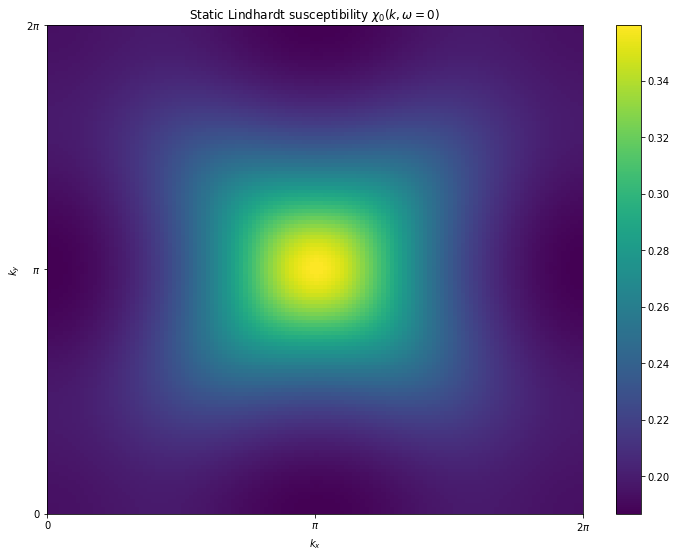

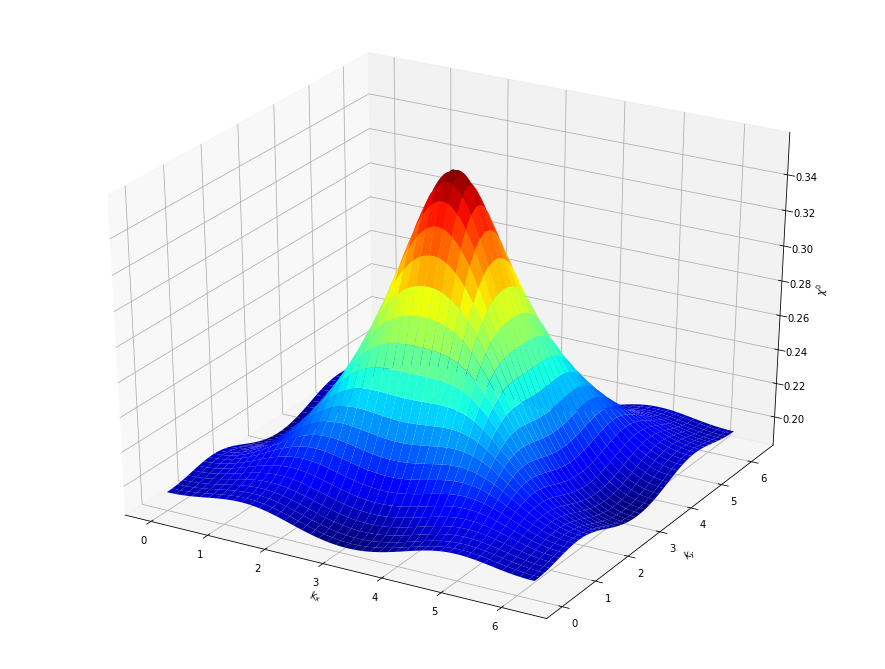

In [42]:
# Make a simple 2d grid
nk = g0.mesh[0].linear_dims[0] + 1       # Retrieve the number of n_k points in g, add one for ki = \pi
k = np.linspace(0, 2*pi, nk, endpoint=True)
kx, ky = np.meshgrid(k, k)

chi = lambda kx, ky: chi0_kw((kx,ky,0), 0).real

# 2d color plot
plt.pcolor(kx, ky, np.vectorize(chi)(kx,ky))
plt.xlim(0, 2*pi); plt.ylim(0, 2*pi)
# decoration
plt.colorbar()
plt.xticks([0, pi, 2*pi],[r"0",r"$\pi$",r"$2\pi$"])    
plt.yticks([0, pi, 2*pi],[r"0",r"$\pi$",r"$2\pi$"])
plt.title('Static Lindhardt susceptibility $\chi_0(k, \omega=0)$')
plt.xlabel(r'$k_x$'); plt.ylabel(r'$k_y$')

# Here is a 3d plot. 
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(kx, ky, np.vectorize(chi)(kx,ky), cmap="jet")
# decoration
ax.set_xlabel(r"$k_x$"); ax.set_ylabel(r"$k_y$")
ax.set_zlabel(r"$\chi^{0}$");

### Structure in Matsubara frequency $i\omega_n$

Check that the Matsubara frequency window used $n_w$ is sufficient to capture the frequency dependence of $\chi_0(\mathbf{k}, i\omega_n)$ by plotting it as a function of frequency for some momentum $\mathbf{k}$

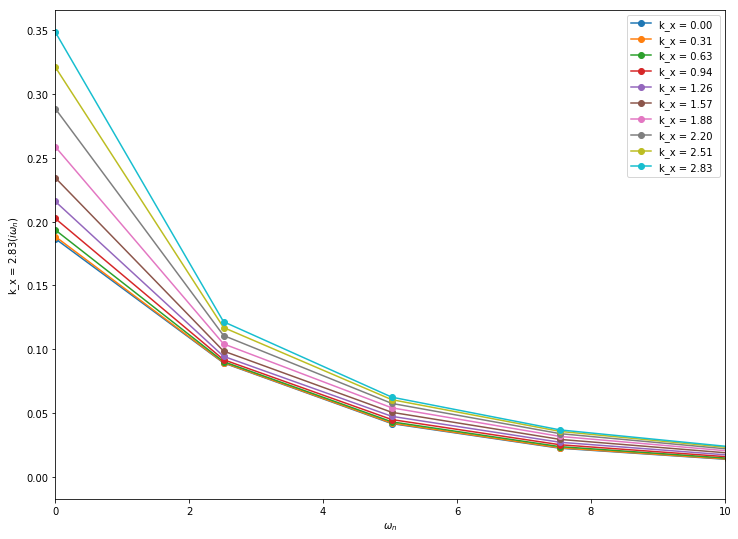

In [43]:
for k in np.arange(0,pi, pi/10):
    oplot(chi0_kw( (k, pi, 0), all).real, '-o', name = "k_x = %1.2f"%k)
plt.xlim((0,10));

## Static susceptibility $\chi_0(\mathbf{k}, \omega=0)$ along high symmetry paths in the Brillouin zone

The static susceptibility along the high-symmetry path $\Gamma-X-M-\Gamma$ shows a dramatic enhancement at $\mathbf{k} = (\pi, \pi)$ due to the perfectly nested Fermi surface.

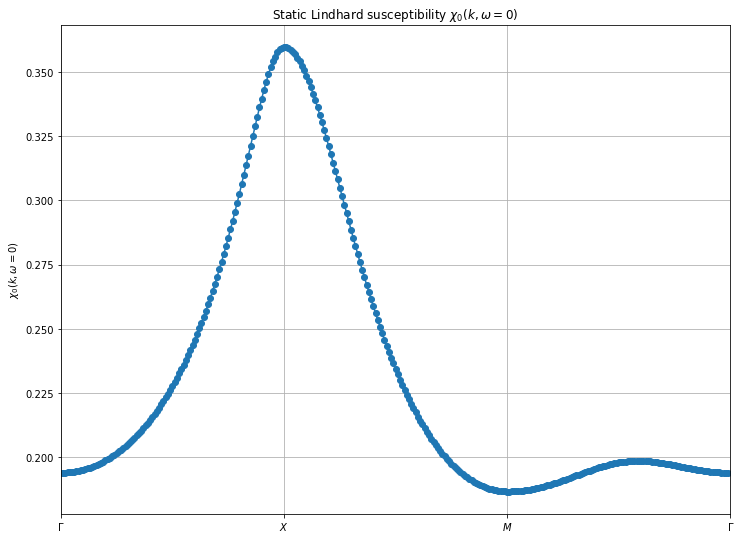

In [44]:
import itertools
n_step = 100
def path(ki, kf):   # generates a linear set of points between ki and kf
    for x in np.arange(0, 1, 1./n_step):
        yield (1-x) * np.array(ki) + x * np.array(kf) 

G = (0,  0 , 0)
X = (pi, pi, 0) 
M = (pi, 0,  0)
    
plt.plot([chi0_kw(k,0).real for k in itertools.chain(path(G, X), path(X, M), path(M, G) )], '-o')
plt.xlim(0, 3*n_step) # window size
plt.grid()
plt.axes().set_xticks([0, n_step, 2*n_step, 3*n_step])
plt.axes().set_xticklabels([r'$\Gamma$',r'$X$',r'$M$',r'$\Gamma$']);
plt.title('Static Lindhard susceptibility $\chi_0(k,\omega=0)$')
plt.ylabel(r'$\chi_0(k,\omega=0)$');